# Deep learning -  Opdracht sessie 02 - CNN

## Doelstelling van de opdracht

Op het vlak van image recognition zijn de convolutional neural networks (en varianten ervan) nagenoeg onovertroffen.
In deze opdracht zullen ze worden ingezet voor het herkennen van kledij, gezichtsexpressies en tot slot bij een autodetectiesysteem. Bij het uitvoeren ervan zal je leren hoe deze CNN's werken en welke hyperparameters getuned moeten worden. Bovendien zal je werken met kleurafbeeldingen waardoor je 4D tensors bekomt (3D afbeeldingen + 1 dimensie voor alle gestackte afbeeldingen).
Naast het trainen van een eigen ontworpen CNN zal je ook gebruik maken van pretrained netwerken en deze via transfer learning deels hertrainen in functie van jouw eigen classificatieprobleem.

In [57]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import matplotlib.image as mpimg
from skimage.io import imread, imsave, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
import sklearn.metrics as metrics
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

import re

#K.set_image_dim_ordering('tf')
plt.rcParams['image.cmap'] = 'gray'
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)


# GPU support 

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [31]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Malaria Classification

Ontwerp en train een CNN dat is in staat is met Malaria geïnfecteerde cellen van niet-geïnfecteerde cellen te onderscheiden.

De data is te vinden in:
- './Malaria/train/infected/': afbeelding van met Malaria geïnfecteerde cellen om mee te trainen.
- './Malaria/train/uninfected/': afbeeldingen van gezonde, niet-geïnfecteerde cellen om mee te trainen.
- './Malaria/test/infected/': afbeelding van met Malaria geïnfecteerde cellen om mee te testen.
- './Malaria/test/uninfected/': afbeeldingen van gezonde, niet-geïnfecteerde cellen om mee te testen.


1. Ontwerp in eerste instantie een eigen CNN. 
- Probeer de accuracy van het CNN op de test data zo hoog mogelijk te krijgen. Dit kan bijvoorbeeld omvatten: hyperparameter tuning van de het netwerk zelf, early stopping, image augmentation of eigen bedachte (pre)-processing technieken. 
- Stel nu dat aan het CNN de vereiste wordt gesteld dat het aantal false negatives (het netwerk voorspelt niet-geïnfecteerd terwijl ze wel geïnfecteerd zijn) op de test set maximaal 1% mag bedragen. Welke aanpassingen zou je doen? Voor deze aanpassingen uit en toon aan dat het aantal false negatives tot maximum 1% is gezakt. Welke accuracy haal je nog?

2. Voer transfer learning uit. Hertrain het VGG19 netwerk voor het classificeren van de al dan niet met Malaria geïnfecteerde cellen. Vergelijk de resultaten met deze van het eigen CNN in termen van accuraatheid, f1-score, snelheid van training, de benodigde hoeveelheid training data, etc.



### Malaria detection via eigen CNN

In [86]:
# Inlezen van de data

# Lezen en preprocessen 

image_size = 75  # hoogte en breedte van de afbeeldingen na resizing. Pas gerust aan.
nr_train_images = 15000  # Om het aantal afbeelding in de training set te beperken. Verhoog indien jouw systeem het toelaat.
nr_test_images = 5000 # Om het aantal afbeelding in de test set in eerste instantiete beperken. 
infected_train_images = []
infected_test_images = []
uninfected_train_images = []
uninfected_test_images = []
y_infected_train = []
y_uninfected_train = []
y_infected_test = []
y_uninfected_test =[]

# read infected train_images
path = './Malaria/train/infected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_train_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    infected_train_images.append(im)
    y_infected_train.append(1)
    
# read infected test_images

path = './Malaria/test/infected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_test_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f))
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    infected_test_images.append(im)
    y_infected_test.append(1)
    

# read uninfected train_images
path = './Malaria/train/uninfected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_train_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    uninfected_train_images.append(im)
    y_uninfected_train.append(0)


# read uninfected test_images

path = './Malaria/test/uninfected/'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_test_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    uninfected_test_images.append(im)
    y_uninfected_test.append(0)

In [87]:
# Uitwerking Malaria detectie
X_train = np.array(infected_train_images + uninfected_train_images)
X_test = np.array(infected_test_images + uninfected_test_images)
y_train = np.array(y_infected_train + y_uninfected_train)
y_test = np.array(y_infected_test + y_uninfected_test)
print(len(y_train))

24633


In [88]:
print(X_train.shape)

(24633, 75, 75, 3)


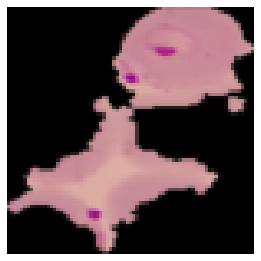

In [89]:
imshow(X_train[1005])
plt.axis('off');

In [90]:
# Normalisatie
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train[1005][2]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000

In [91]:
y_train_ohe = to_categorical(y_train)
y_train_ohe

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [92]:
X_train.shape

(24633, 75, 75, 3)

In [93]:
def create_cnn(odim=y_train_ohe.shape[1],
               img_rows = X_train.shape[1],
               img_cols = X_train.shape[2],
               img_chs = X_train.shape[3],
               dropout = 0.2,
               n_conv = 32,
               kernel_size = (3, 3),
               hidden_activation = 'relu',
               pool_size = (2, 2),
               batch_norm = 0,
               neurons = 50,
               final_activation = 'softmax',
               loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metric = 'accuracy'
              ):
    input_shape = (img_rows, img_cols, img_chs)
    
    # Model
    model = Sequential()
    
    model.add(Conv2D(n_conv, kernel_size=kernel_size, activation=hidden_activation, input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout)) # Value between 0 and 1 
    if batch_norm == 1:
        model.add(BatchNormalization())
    
    model.add(Conv2D(n_conv, kernel_size, activation=hidden_activation)) 
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout)) # Value between 0 and 1 
    if batch_norm == 1:
        model.add(BatchNormalization())
    
    model.add(Flatten()) 
    model.add(Dense(neurons, activation=hidden_activation)) 
    model.add(Dropout(dropout)) # Value between 0 and 1 
    
    model.add(Dense(odim, activation=final_activation))
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metric])
    
    return model

def model_history(epochs, metric1='loss', metric2='accuracy'):
    metric1val = f'val_{metric1}'
    metric2val = f'val_{metric2}'
    epochlist = np.linspace(1, epochs, epochs)
    
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('History plots', size='xx-large')
    colors = sns.color_palette()
    
    sns.lineplot(x=epochlist, y=history.history[metric1], color=colors[0], ax=ax1, label=metric1, legend=False)
    ax1.title.set_text('Training error')
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    ax2 = ax1.twinx()
    sns.lineplot(x=epochlist, y=history.history[metric1val], color=colors[1], ax=ax2, label=metric1val, legend=False)
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_a = lines_1 + lines_2
    labels_a = labels_1 + labels_2
    ax2.legend(lines_a, labels_a, loc=0)
    
    sns.lineplot(x=epochlist, y=history.history[metric2], color=colors[0], ax=ax3, label=metric2, legend=False)
    ax3.title.set_text('Accuracy')
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    ax4 = ax3.twinx()
    sns.lineplot(x=epochlist, y=history.history[metric2val], color=colors[1], ax=ax4, label=metric2val, legend=False);
    lines_4, labels_4 = ax4.get_legend_handles_labels()
    lines_b = lines_3 + lines_4
    labels_b = labels_3 + labels_4
    ax4.legend(lines_b, labels_b, loc=0)
    
    plt.show()

def model_evaluation(estimator = create_cnn(), 
                     y_test = y_test,
                     X_test = X_test,
                     output_dim = y_train_ohe.shape[1]
                    ):
    
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    
    print('\n')
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
    print('\n')
    if output_dim == 2:
        RocCurveDisplay.from_predictions(y_test, y_pred, name='ROC Curve')
        plt.show()
    print('\n')

In [94]:
batch_size = 16 # 
epochs = 50 # 

# Maken van model
model = create_cnn(odim=y_train_ohe.shape[1],
                   img_rows = X_train.shape[1],
                   img_cols = X_train.shape[2],
                   img_chs = X_train.shape[3],
                   dropout = 0.3,
                   n_conv = 64,
                   kernel_size = (3, 3),
                   hidden_activation = 'relu',
                   pool_size = (2, 2),
                   batch_norm = 1,
                   neurons = 40,
                   final_activation = 'softmax',
                   loss = 'categorical_crossentropy',
                   optimizer = 'adam',
                   metric = 'accuracy')

# Trainen van het CNN
history = model.fit(X_train, y_train_ohe,batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Epoch 1/50
1232/1232 [==============================] - 6s 5ms/step - loss: 0.5659 - accuracy: 0.7223 - val_loss: 0.5672 - val_accuracy: 0.6949
Epoch 2/50
1232/1232 [==============================] - 5s 4ms/step - loss: 0.4658 - accuracy: 0.7574 - val_loss: 0.5110 - val_accuracy: 0.8482
Epoch 3/50
1232/1232 [==============================] - 5s 4ms/step - loss: 0.3029 - accuracy: 0.8660 - val_loss: 0.3145 - val_accuracy: 0.9901
Epoch 4/50
1232/1232 [==============================] - 5s 4ms/step - loss: 0.2374 - accuracy: 0.9070 - val_loss: 0.2449 - val_accuracy: 0.9880
Epoch 5/50
1232/1232 [==============================] - 5s 4ms/step - loss: 0.2213 - accuracy: 0.9176 - val_loss: 0.1273 - val_accuracy: 0.9917
Epoch 6/50
1232/1232 [==============================] - 5s 4ms/step - loss: 0.2009 - accuracy: 0.9254 - val_loss: 0.2296 - val_accuracy: 0.9850
Epoch 7/50
1232/1232 [==============================] - 5s 4ms/step - loss: 0.1952 - accuracy: 0.9255 - val_loss: 0.0953 - val_accuracy:

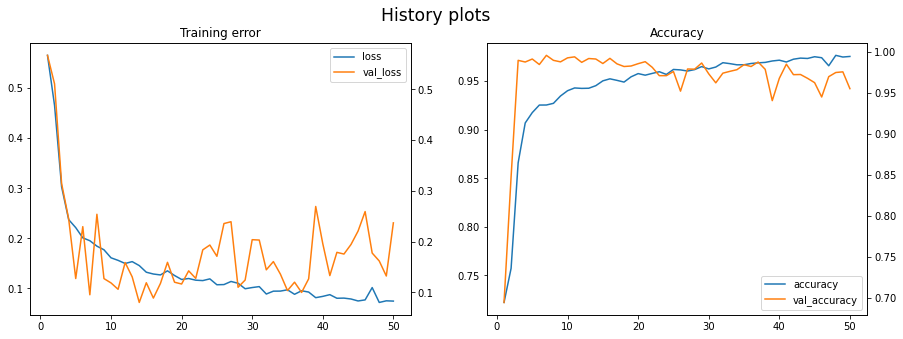

In [95]:
model_history(epochs, metric1='loss', metric2='accuracy')



              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3000
           1       0.95      0.91      0.93      3000

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

Accuracy: 	93.53333333333333%



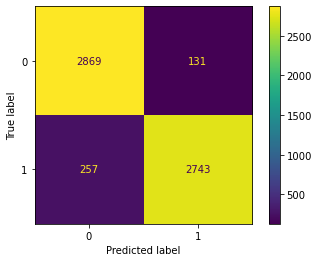

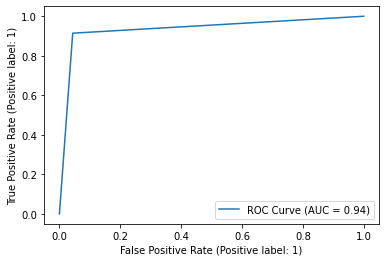

In [96]:
model_evaluation(estimator = model, 
                     y_test = y_test,
                     X_test = X_test,
                     output_dim = y_train_ohe.shape[1]
                    )

In [ ]:
# Conclusies




### Transfer learning
Hertrain het VGG19 netwerk (of optioneel ResNet) op de malaria dataset. Vergelijk de resultaten met deze van het eigen CNN in termen van accuraatheid, f1-score, snelheid van training, de benodigde hoeveelheid training data, etc.


In [4]:
# Uitwerking transfer learning



In [6]:
# Conclusies transfer learning



## Facial expressions classification

Het bestand ("facial_expressions.csv") bevat tienduizenden afbeeldingen met gezichtsexpressies.
Elke grijsafbeelding is 48x48 pixels groot en behoort tot één van de volgende 7 klasses:
(0=Boos, 1=Afkeer, 2=Bang, 3=Blij, 4=Verdrietig, 5=Verrast, 6=Neutraal)

De dataset is verdeeld in drie stukken:
1. 'Training' gebruikt voor training.
2. 'PrivateTest' gebruikt voor testing.
3. 'PublicTest' gebruikt voor evaluatie bij publieke competities (hier niet nodig).
Je kan filteren via de 'USAGE' kolom

Een bijkomende moeilijkheid is dat de pixelintensiteiten van een afbeelding als 1 string zijn opgeslagen gescheiden door een spatie. Je zal zelf deze string moeten opsplitsen in individuele pixels.

- De bedoeling is om een zo performant mogelijke CNN te trainen in termen van accuracy.
- Bekijk de confusion matrix. Zijn er expressies die meer of minder goed herkend worden?
- Welke expressies worden het meest met elkaar verward. Baseer je ook hier op de confusion matrix.


In [9]:
dataset = pd.read_csv('./facial_expressions.csv')
dataset.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


## Car detection system

De uiteindelijke bedoeling is om een werkende car detector te bouwen die in staat is om in een afbeelding (of video) auto's met een hoge accuraatheid te detecteren en er een bounding box omheen te tekenen, zoals op onderstaand voorbeeld.

![alt text](./JupyterImages/cardetectionExample.png "Title")

De opdracht kan in twee stukken opgedeeld worden:
1. Trainen van een CNN voor het classificeren van auto's. 
2. Detectie van de auto's in een afbeelding door met een in grootte variërend window de afbeelding af te scannen en elke subafbeelding door de in stap 1 getrainde classifiër te sturen.



### Stap 1. Car classifier

De map "vehicles" bevat duizenden kleurafbeeldingen van auto's, de map "non-vehicles" van niet-auto's.

- Maak van deze afbeeldingen gebruik om een accurate binaire CNN classifier (auto of niet-auto) te trainen. Bepaal daarbij zelf de architectuur, hyperparamters, grootte van test- en training set.

- Hertrain het VGG19-net als car detector. Vergelijk de accuracy met de accuracy van het eigen ontworpen CNN.

**Opmerkingen:**

- Omwille van het groot aantal afbeeldingen is het inladen ervan vrij geheugenintensief. Daarom is het aan te raden maar een deel van de afbeeldingen te gebruiken. Achteraf kan je de dataset uitbreiden als jouw computer dat toelaat.
- Normaliseer de afbeeldingen naar floats tussen 0 en 1.

```Python
X_car = X_car.astype('float32')`
X_car /= 255```





In [ ]:
# Uitwerking van de car classifier



### Stap 2.  Sliding window detection

Om nu een auto te detecteren in een grotere afbeelding (locatie van de auto in een foto) ga je als volgt te werk:
Via een for loop kan je de afbeelding meerdere malen afscannen telkens met een in grootte varierend window. Classificeer nu telkens de subafbeelding die zich onder het window bevindt. Teken een bounding box rond de gedetecteerde auto.
Gebruik als classifier ofwel het eigen CNN of de hertrainde VGG19 classifier.

In de map "StreetImages" zitten enkele afbeeldingen die je kan gebruiken om de detector op los te laten

Belangrijk is niet alleen te optimalizeren voor detectie accuraatheid maar ook naar **detectiesnelheid**.

Voor het tekenen van de bounding box kan volgende code gebruikt worden:
```python
def rectangle_perimeter(r0, c0, width, height, shape=None, clip=False):
    rr, cc = [r0, r0 + width, r0 + width, r0], [c0, c0, c0 + height, c0 + height]
    return skimage.draw.polygon_perimeter(rr, cc, shape=shape, clip=clip)

# tekenen van bounding box:
rr, cc = rectangle_perimeter(y, x, w, w)
image_detected[rr,cc] =255

```

Eenzelfde auto zal normaal gezien door meerdere boundingboxes aangeduid zijn. Zoek een manier om boundingboxes die heel dicht op elkaar liggen tot één enkele bounding box te herleiden.

Een methode die in de praktijk dikwijls toepast wordt om redundantie boundingboxes te verwijderen is de Non-Maximum Suppression. Meer info is te vinden op https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
Het is niet vereist deze non-maximum suppression bij deze opdracht toe te passen. 


In [5]:
# Uitwerking sliding window detection.

